In [213]:
using JuMP
using HiGHS
using LinearAlgebra
using Random
using Plots

In [214]:
function leer_archivo_tsp(archivo)
    coordenadas = []
    open(archivo, "r") do f
        en_seccion = false
        for linea in eachline(f)
            if occursin("NODE_COORD_SECTION", linea)
                en_seccion = true
                continue
            elseif occursin("EOF", linea)
                break
            end
            
            if en_seccion
                partes = split(linea)
                if length(partes) >= 3
                    id = parse(Int, partes[1])
                    lat = parse(Float64, partes[2])
                    lon = parse(Float64, partes[3])
                    push!(coordenadas, (id, lat, lon))
                end
            end
        end
    end
    return coordenadas
end

# Función para calcular distancia entre dos puntos
function calcular_distancia_entre(punto1, punto2)
    lat1, lon1 = punto1[2], punto1[3]
    lat2, lon2 = punto2[2], punto2[3]
    return sqrt((lat2 - lat1)^2 + (lon2 - lon1)^2)
end

# Función para calcular matriz de distancias completa
function calcular_matriz_distancias(coordenadas)
    n = length(coordenadas)
    distancias = zeros(n, n)
    
    for i in 1:n
        for j in 1:n
            if i != j
                distancias[i,j] = calcular_distancia_entre(coordenadas[i], coordenadas[j])
            end
        end
    end
    return distancias
end

# Función para calcular costo de un tour
function calcular_costo(tour, distancias)
    costo = 0.0
    n = length(tour)
    for i in 1:n-1
        costo += distancias[tour[i], tour[i+1]]
    end
    costo += distancias[tour[end], tour[1]]  # Volver al inicio
    return costo
end

calcular_costo (generic function with 1 method)

In [215]:
function tsp_vecino_mas_cercano(distancias; ciudad_inicial=1)
    n = size(distancias, 1)
    visitado = falses(n)
    tour = [ciudad_inicial]
    visitado[ciudad_inicial] = true
    costo_total = 0.0
    
    println("Construyendo tour con vecino más cercano...")
    
    for paso in 2:n
        ultima_ciudad = tour[end]
        dist_min = Inf
        siguiente_ciudad = 0
        
        # Encontrar la ciudad no visitada más cercana
        for j in 1:n
            if !visitado[j] && distancias[ultima_ciudad, j] < dist_min
                dist_min = distancias[ultima_ciudad, j]
                siguiente_ciudad = j
            end
        end
        
        push!(tour, siguiente_ciudad)
        visitado[siguiente_ciudad] = true
        costo_total += dist_min
        
        if paso % 20 == 0
            println("  Visitadas $paso/$n ciudades...")
        end
    end
    
    # Volver al inicio
    costo_total += distancias[tour[end], tour[1]]
    
    println("Tour voraz completado - Costo: $costo_total")
    return tour, costo_total
end

tsp_vecino_mas_cercano (generic function with 1 method)

In [216]:
function combinar_soluciones(tour_heuristico, tour_sub, indices_sub, distancias)
    n_total = size(distancias, 1)
    println("Combinando soluciones...")
    
    # Si no tenemos solución del subconjunto, devolver la heurística
    if isempty(tour_sub)
        println("No hay tour de subconjunto para combinar")
        return tour_heuristico
    end
    
    # VERIFICACIÓN DE SEGURIDAD
    k = length(indices_sub)
    println("Tamaño del subconjunto: $k")
    println("Tour subconjunto recibido: $tour_sub")
    println("Índices subconjunto: $indices_sub")
    
    # Verificar que todos los índices en tour_sub sean válidos
    for i in tour_sub
        if i < 1 || i > k
            println("ERROR: Índice $i en tour_sub está fuera del rango [1, $k]")
            println("Tour subconjunto inválido, usando solución heurística")
            return tour_heuristico
        end
    end
    
    # Mapear tour del subconjunto a índices originales - FORMA CORRECTA
    tour_sub_original = indices_sub[tour_sub]
    println("Tour subconjunto mapeado a índices originales: $tour_sub_original")
    
    # Ciudades que no están en el subconjunto
    todas_ciudades = Set(1:n_total)
    ciudades_sub = Set(tour_sub_original)
    ciudades_restantes = setdiff(todas_ciudades, ciudades_sub)
    
    println("Ciudades en subconjunto: $(length(ciudades_sub))")
    println("Ciudades restantes: $(length(ciudades_restantes))")
    
    # Empezar con el tour del subconjunto
    tour_combinado = copy(tour_sub_original)
    
    # Insertar ciudades restantes usando inserción más barata
    for (idx, ciudad) in enumerate(ciudades_restantes)
        mejor_costo = Inf
        mejor_posicion = 1
        
        for pos in 1:length(tour_combinado)
            # Calcular costo de insertar después de la posición pos
            if pos == length(tour_combinado)
                # Insertar al final (conexión circular)
                costo_insercion = (distancias[tour_combinado[end], ciudad] +
                                  distancias[ciudad, tour_combinado[1]] -
                                  distancias[tour_combinado[end], tour_combinado[1]])
            else
                # Insertar entre pos y pos+1
                costo_insercion = (distancias[tour_combinado[pos], ciudad] +
                                  distancias[ciudad, tour_combinado[pos+1]] -
                                  distancias[tour_combinado[pos], tour_combinado[pos+1]])
            end
            
            if costo_insercion < mejor_costo
                mejor_costo = costo_insercion
                mejor_posicion = pos
            end
        end
        
        # Insertar en la mejor posición
        if mejor_posicion == length(tour_combinado)
            push!(tour_combinado, ciudad)
        else
            insert!(tour_combinado, mejor_posicion + 1, ciudad)
        end
        
        if idx % 20 == 0
            println("  Insertadas $idx/$(length(ciudades_restantes)) ciudades...")
        end
    end
    
    # VERIFICAR que el tour final es válido
    if length(tour_combinado) != n_total
        println("ERROR: Tour combinado tiene longitud $(length(tour_combinado)) pero debería tener $n_total")
        println("Usando solución heurística en su lugar")
        return tour_heuristico
    end
    
    if length(unique(tour_combinado)) != n_total
        println("ERROR: Tour combinado tiene ciudades duplicadas")
        println("Usando solución heurística en su lugar")
        return tour_heuristico
    end
    
    costo_final = calcular_costo(tour_combinado, distancias)
    println("Combinación completada - Costo: $costo_final")
    
    return tour_combinado
end

# 2-opt CORRECTO (LENTO pero funciona)
function mejorar_tour_2opt_lento(tour, distancias; max_iteraciones=100)
    n = length(tour)
    mejor_tour = copy(tour)
    mejor_costo = calcular_costo(mejor_tour, distancias)
    
    println("   Iniciando 2-opt (esto tomará tiempo)...")
    println("   Costo inicial: $mejor_costo")
    
    for iteracion in 1:max_iteraciones
        mejora_encontrada = false
        
        for i in 1:n-1
            for j in i+2:min(n, i+n-1)  # j desde i+2 hasta n
                # Calcular cambio si intercambiamos aristas (i, i+1) y (j, j+1)
                # Por (i, j) y (i+1, j+1)
                
                # Índices circulares
                i1 = i
                i2 = (i % n) + 1
                j1 = j 
                j2 = (j % n) + 1
                
                # Nodos actuales
                a = mejor_tour[i1]
                b = mejor_tour[i2] 
                c = mejor_tour[j1]
                d = mejor_tour[j2]
                
                costo_actual = distancias[a, b] + distancias[c, d]
                costo_nuevo = distancias[a, c] + distancias[b, d]
                
                if costo_nuevo < costo_actual - 1e-10
                    # Aplicar el swap: invertir segmento entre i+1 y j
                    if i2 < j1
                        reverse!(mejor_tour, i2, j1)
                    else
                        reverse!(mejor_tour, j1, i2)
                    end
                    mejor_costo += costo_nuevo - costo_actual
                    mejora_encontrada = true
                    break
                end
            end
            if mejora_encontrada
                break
            end
        end
        
        if !mejora_encontrada
            println("   No más mejoras en iteración $iteracion")
            break
        end
        
        if iteracion % 10 == 0
            println("   Iteración $iteracion - Mejor costo: $mejor_costo")
        end
    end
    
    return mejor_tour, mejor_costo
end

# Seleccionar ciudades IMPORTANTES (las que tienen conexiones largas)
function seleccionar_ciudades_importantes(tour, distancias, k)
    n = length(tour)
    # Calcular "importancia" de cada ciudad (longitud de sus conexiones)
    importancia = zeros(n)
    
    for i in 1:n
        previo = (i == 1) ? tour[n] : tour[i-1]
        siguiente = (i == n) ? tour[1] : tour[i+1]
        importancia[tour[i]] = distancias[previo, tour[i]] + distancias[tour[i], siguiente]
    end
    
    # Seleccionar las k ciudades más importantes
    ciudades_ordenadas = sort(1:n, by=i->importancia[i], rev=true)
    return ciudades_ordenadas[1:min(k, n)]
end

# Resolver TSP ÓPTIMO para subconjunto pequeño
function resolver_tsp_optimo_subconjunto_simple(ciudades, distancias)
    k = length(ciudades)
    println("   Resolviendo TSP óptimo para $k ciudades...")
    
    model = Model(HiGHS.Optimizer)
    
    @variable(model, x[1:k, 1:k], Bin)
    
    # Restricciones
    for i in 1:k
        @constraint(model, x[i,i] == 0)
        @constraint(model, sum(x[i,j] for j in 1:k) == 1)
        @constraint(model, sum(x[j,i] for j in 1:k) == 1)
    end
    
    @objective(model, Min, sum(distancias[ciudades[i], ciudades[j]] * x[i,j] for i in 1:k, j in 1:k))
    
    optimize!(model)
    
    if termination_status(model) == MOI.OPTIMAL
        println("   Solución óptima encontrada!")
        x_vals = value.(x)
        
        # ENFOQUE SIMPLE: Usar el orden natural como fallback
        # Pero primero intentar reconstruir el tour correctamente
        
        tour_sub = Int[]
        visitado = falses(k)
        
        # Empezar desde ciudad 1
        actual = 1
        push!(tour_sub, actual)
        visitado[actual] = true
        
        for paso in 2:k
            siguiente_encontrado = false
            for j in 1:k
                if !visitado[j] && x_vals[actual, j] > 0.5
                    actual = j
                    push!(tour_sub, actual)
                    visitado[actual] = true
                    siguiente_encontrado = true
                    break
                end
            end
            
            if !siguiente_encontrado
                # Fallback: agregar la primera ciudad no visitada
                for j in 1:k
                    if !visitado[j]
                        actual = j
                        push!(tour_sub, actual)
                        visitado[actual] = true
                        siguiente_encontrado = true
                        break
                    end
                end
            end
        end
        
        println("   Tour reconstruido: $tour_sub")
        return tour_sub
        
    else
        println("   No se encontró solución óptima")
        return collect(1:k)
    end
end

resolver_tsp_optimo_subconjunto_simple (generic function with 1 method)

In [217]:
function resolver_tsp_realista(archivo_tsp)
    println("=== ESTRATEGIA REALISTA PARA TSP ===")
    
    # 1. CARGAR DATOS
    coordenadas = leer_archivo_tsp(archivo_tsp)
    n = length(coordenadas)
    println("Ciudades: $n")
    
    # 2. HEURÍSTICA VORAZ (rápida)
    println("\n1. Heurística voraz...")
    distancias = calcular_matriz_distancias(coordenadas)
    tour_voraz, costo_voraz = tsp_vecino_mas_cercano(distancias)
    println("   Costo voraz: $costo_voraz")
    
    # 3. 2-opt MEJORADO (lento pero necesario)
    println("\n2. 2-opt mejorado...")
    tour_mejorado, costo_mejorado = mejorar_tour_2opt_lento(tour_voraz, distancias)
    println("   Costo después de 2-opt: $costo_mejorado")
    
    # 4. PROGRAMACIÓN LINEAL en subconjunto PEQUEÑO
    println("\n3. Programación Lineal en subconjunto...")
    
    # Seleccionar 10-15 ciudades MÁS IMPORTANTES
    ciudades_importantes = seleccionar_ciudades_importantes(tour_mejorado, distancias, 12)
    println("   Ciudades importantes seleccionadas: $ciudades_importantes")
    
    # Resolver TSP ÓPTIMO para ese subconjunto
    tour_optimo_sub = resolver_tsp_optimo_subconjunto(ciudades_importantes, distancias)
    
    # 5. COMBINAR resultados
    println("\n4. Combinando soluciones...")
    tour_final = combinar_tours(tour_mejorado, tour_optimo_sub, ciudades_importantes, distancias)
    costo_final = calcular_costo(tour_final, distancias)
    
    println("\n=== RESULTADO FINAL ===")
    println("Costo inicial (voraz): $costo_voraz")
    println("Costo final: $costo_final")
    println("Mejora: $(costo_voraz - costo_final)")
    
    return tour_final, costo_final
end

resolver_tsp_realista (generic function with 1 method)

In [218]:
function resolver_tsp_acelerado(archivo_tsp)
    println("=== ESTRATEGIA ACELERADA PARA 200 CIUDADES ===")
    
    # carga datos
    coordenadas = leer_archivo_tsp(archivo_tsp)
    n = length(coordenadas)
    println("Ciudades: $n")
    
    # heuristica voraz
    println("\n1. Heurística voraz...")
    distancias = calcular_matriz_distancias(coordenadas)
    tour_voraz, costo_voraz = tsp_vecino_mas_cercano(distancias)
    println("   Costo voraz: $costo_voraz")
    
    # 2-opt con pocas iteraciones
    println("\n2. 2-opt acelerado ...")
    tour_mejorado, costo_mejorado = mejorar_tour_2opt_lento(tour_voraz, distancias, max_iteraciones=20)
    println("   Costo después de 2-opt: $costo_mejorado")
    
    # PL en programa reducido
    num_ciudades = 8
    println("\n3. Programación Lineal en subconjunto de $num_ciudades ciudades...")
    ciudades_importantes = seleccionar_ciudades_importantes(tour_mejorado, distancias, num_ciudades)
    println("   Ciudades importantes seleccionadas: $ciudades_importantes")
    
    tour_optimo_sub = resolver_tsp_optimo_subconjunto(ciudades_importantes, distancias)
    
    # combinar
    println("\n4. Combinando soluciones...")
    tour_final = combinar_soluciones(tour_mejorado, tour_optimo_sub, ciudades_importantes, distancias)
    costo_final = calcular_costo(tour_final, distancias)
    
    println("\n=== RESULTADO FINAL ===")
    println("Costo inicial (voraz): $costo_voraz")
    println("Costo final: $costo_final")
    println("Mejora: $(costo_voraz - costo_final)")
    
    return tour_final, costo_final
end

resolver_tsp_acelerado (generic function with 1 method)

In [219]:
tour_final, costo_final = resolver_tsp_acelerado("../data/input/gr202.tsp")

=== ESTRATEGIA ACELERADA PARA 200 CIUDADES ===
Ciudades: 202

1. Heurística voraz...
Construyendo tour con vecino más cercano...
  Visitadas 20/202 ciudades...
  Visitadas 40/202 ciudades...
  Visitadas 60/202 ciudades...
  Visitadas 80/202 ciudades...
  Visitadas 100/202 ciudades...
  Visitadas 120/202 ciudades...
  Visitadas 140/202 ciudades...
  Visitadas 160/202 ciudades...
  Visitadas 180/202 ciudades...
  Visitadas 200/202 ciudades...
Tour voraz completado - Costo: 619.3953534350103
   Costo voraz: 619.3953534350103

2. 2-opt acelerado ...
   Iniciando 2-opt (esto tomará tiempo)...
   Costo inicial: 619.3953534350103
   Iteración 10 - Mejor costo: 584.8290142052202
   Iteración 20 - Mejor costo: 573.307226160546
   Costo después de 2-opt: 573.307226160546

3. Programación Lineal en subconjunto de 8 ciudades...
   Ciudades importantes seleccionadas: [76, 1, 74, 75, 66, 25, 2, 68]
   Resolviendo TSP óptimo para 8 ciudades...
Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c

([76, 74, 68, 73, 70, 69, 71, 72, 64, 63  …  8, 7, 6, 4, 5, 2, 3, 16, 1, 75], 526.2365555176675)

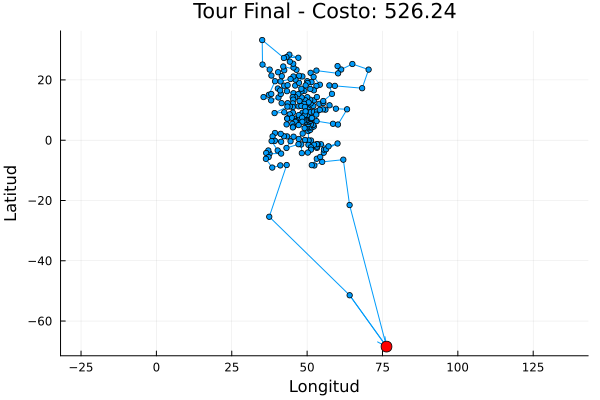

In [220]:
using Plots

function visualizar_tour(coordenadas, tour, titulo="Tour TSP")
    # Extraer coordenadas
    lats = [c[3] for c in coordenadas]
    lons = [c[2] for c in coordenadas]
    
    # Ordenar según el tour
    tour_lats = lats[tour]
    tour_lons = lons[tour]
    
    # Cerrar el ciclo (volver al inicio)
    push!(tour_lats, tour_lats[1])
    push!(tour_lons, tour_lons[1])
    
    # Crear el plot
    p = plot(tour_lons, tour_lats, 
             line=:arrow, marker=:circle, markersize=3,
             title=titulo, xlabel="Longitud", ylabel="Latitud",
             legend=false, aspect_ratio=:equal)
    
    # Marcar el inicio
    scatter!([tour_lons[1]], [tour_lats[1]], markersize=6, color=:red)
    
    return p
end

# Visualizar el tour final
coordenadas_completas = leer_archivo_tsp("../data/input/gr202.tsp")
p = visualizar_tour(coordenadas_completas, tour_final, "Tour Final - Costo: $(round(costo_final, digits=2))")
display(p)